In [1]:
import sunpy.map
import sunpy.visualization.colormaps as cm
import sunpy.sun.constants
from sunpy.map.maputils import all_coordinates_from_map, coordinate_is_on_solar_disk
from aiapy.calibrate import register, update_pointing,normalize_exposure

import astropy.units as u
from astropy.constants import G, M_sun, R_sun, au
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy.units import imperial
from astropy.stats import gaussian_fwhm_to_sigma

import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
import plotly.tools as tls
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import numpy as np
import pandas as pd
import math
from math import pi
import glob
import time
import datetime
import os
import importlib
import warnings

from PIL import Image
from fpdf import FPDF

import aia_part
from aia_part.pixel_to_world.std_pixel_to_world import std_pixel_to_world
from aia_part.pixel_to_world.my_pixel_to_world import my_pixel_to_world
from aia_part.calculate_DN import calculate_DN
from aia_part.gaussian_fit_aia import gaussian_fit_aia
from aia_part.data.constant import wavelength_list_aia_absolute

# AIA_basic
load AIA in 4 years
timeinterval :1 day

In [ ]:
# aia_path="data/AIA/aia_lev1_304a_2011_02_03t00_00_32_12z_image_lev1.fits"
aia_files = sorted(glob.glob('aia_part\\data\\AIA\\*image_lev1.fits'))
len(aia_files)

In [4]:
datetime.datetime.strptime?

Docstring: string, format -> new datetime parsed from a string (like time.strptime()).
Type:      builtin_function_or_method

In [7]:
dt = datetime.datetime.strptime(aia_maps[0].meta['t_obs'],
                               '%Y-%m-%dT%H:%M:%S.%fZ')
dt

datetime.datetime(2011, 2, 3, 0, 4, 9, 570000)

In [9]:
datetime.datetime.combine(dt.date(), datetime.time.min)

datetime.datetime(2011, 2, 3, 0, 0)

## aiapy level 1.5 process
https://aiapy.readthedocs.io/en/stable/generated/gallery/prepping_level_1_data.html#sphx-glr-generated-gallery-prepping-level-1-data-py

In [7]:
#用aiapy处理sunpy map 得到 level 1.5 的数据，并存成"_adjusted.fits"
error_files=[]
for i in range(len(aia_files)):
    
    try:       
        # Save the adjusted map to a new file
        new_file=aia_files[i].split(sep='\\')
        new_file[2]='AIA_1p5'
        new_file[-1]=new_file[-1].replace('.fits', '_adjusted.fits')         
        new_file= os.path.join(*new_file)
        
        if(os.path.exists(new_file)):
            # print("exist    "+new_file)
            continue
        
    
        # Load the original map from a file
        original_map = sunpy.map.Map(aia_files[i])
        
        rp=[original_map.meta['crpix1'],original_map.meta['crpix2']]
        image_shape=[original_map.meta['naxis1'],original_map.meta['naxis2']]
        
        
        # if(
        # ((rp[0]-image_shape[0]/2)**2+(rp[1]-image_shape[1]/2)**2)/(image_shape[0]*image_shape[1]/4)>0.05
        # ):
        #     print("not center "+new_file)
        #     continue
        

            
            
        # Adjust the map using aiapy functions
        adjusted_map = normalize_exposure(register(update_pointing(original_map)))
        adjusted_map.save(new_file, overwrite=True)
         
        if(i%10==0):
            print(f"Saved adjusted map to {new_file}")

    except:
        error_files.append(aia_files[i])
        print(f"Error  file {aia_files[i]}")

Error  file aia_part\data\AIA\aia_lev1_304a_2011_08_23t00_00_06_20z_image_lev1.fits
Error  file aia_part\data\AIA\aia_lev1_304a_2011_10_27t00_00_06_21z_image_lev1.fits
Error  file aia_part\data\AIA\aia_lev1_304a_2011_12_16t00_00_08_12z_image_lev1.fits


In [ ]:
not center aia_part\data\AIA_1p5\aia_lev1_304a_2011_08_23t00_00_06_20z_image_lev1_adjusted.fits
not center aia_part\data\AIA_1p5\aia_lev1_304a_2011_10_27t00_00_06_21z_image_lev1_adjusted.fits
not center aia_part\data\AIA_1p5\aia_lev1_304a_2011_12_16t00_00_08_12z_image_lev1_adjusted.fits

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2011-08-23 00:00:06
Exposure Time,4.999193 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.600165 0.600165] arcsec / pix
Reference Pixel,[2810.627686 1334.153076] pix

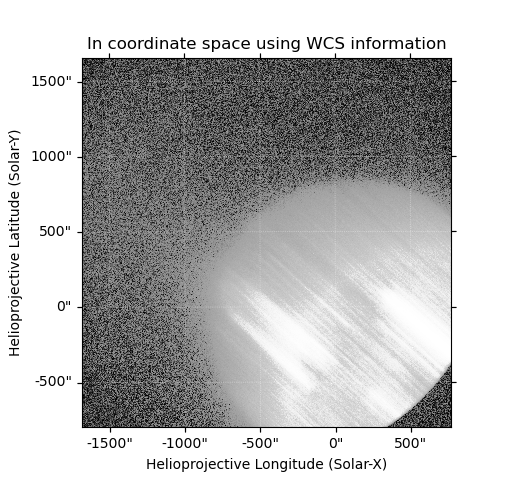
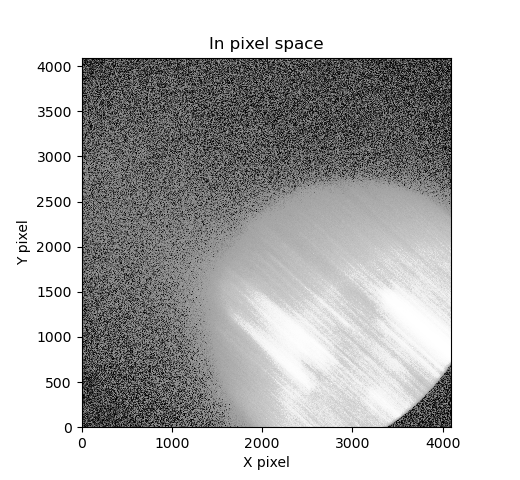
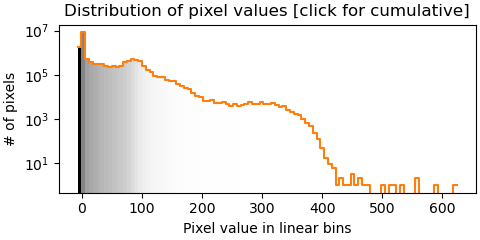
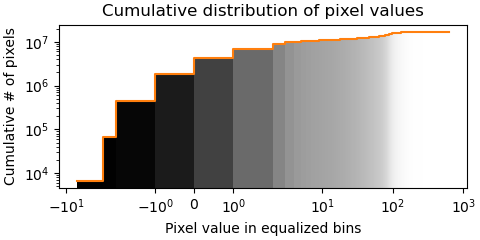

In [2]:
file='aia_part\\data\\AIA\\aia_lev1_304a_2011_08_23t00_00_06_20z_image_lev1.fits'
m=sunpy.map.Map(file)
m

In [22]:
((m.meta['crpix1']-m.meta['naxis1']/2)**2+(m.meta['crpix2']-m.meta['naxis2']/2)**2)/(m.meta['naxis1']*m.meta['naxis2']/4)>0.05

True

In [10]:
adjusted_map = normalize_exposure(register(update_pointing(m)))

ValueError: Input must be a full disk image.

### manual

In [5]:
aia_manual_files=sorted(glob.glob('aia_part\\data\\AIA_manual\\*'))
aia_manual_files

['aia_part\\data\\AIA_manual\\aia_lev1_304a_2011_08_23t01_00_08_12z_image_lev1.fits',
 'aia_part\\data\\AIA_manual\\aia_lev1_304a_2011_10_27t01_00_08_13z_image_lev1.fits',
 'aia_part\\data\\AIA_manual\\aia_lev1_304a_2011_12_16t01_00_08_12z_image_lev1.fits']

In [11]:
original_manual_maps=sunpy.map.Map(aia_manual_files)

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2011-12-16 01:00:08
Exposure Time,2.902055 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.600165 0.600165] arcsec / pix
Reference Pixel,[2060.780029 2036.319946] pix

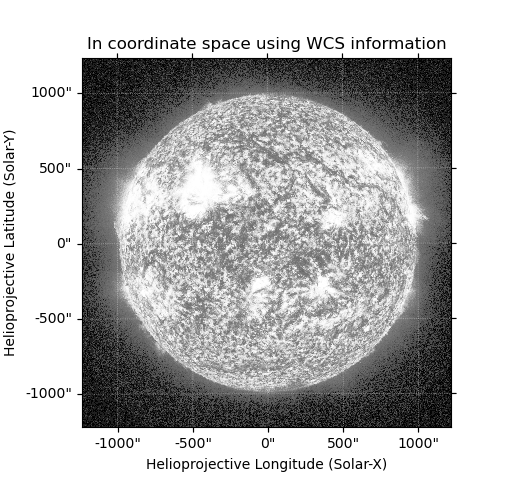
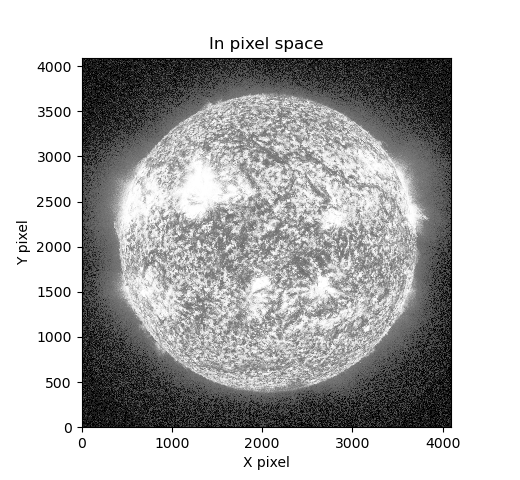
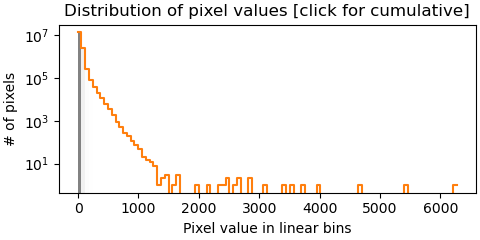
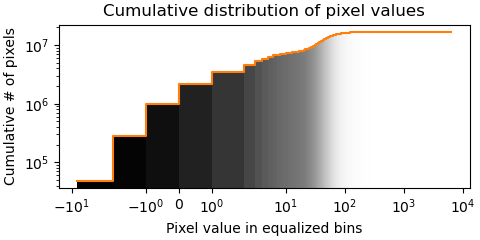

In [14]:
original_manual_maps[2]

In [15]:
aia_manual_files[0].split(sep='\\')

['aia_part',
 'data',
 'AIA_manual',
 'aia_lev1_304a_2011_08_23t01_00_08_12z_image_lev1.fits']

In [19]:
aia_manual_files

['aia_part\\data\\AIA_manual\\aia_lev1_304a_2011_08_23t01_00_08_12z_image_lev1.fits',
 'aia_part\\data\\AIA_manual\\aia_lev1_304a_2011_10_27t01_00_08_13z_image_lev1.fits',
 'aia_part\\data\\AIA_manual\\aia_lev1_304a_2011_12_16t01_00_08_12z_image_lev1.fits']

In [26]:
for i in range(len(aia_manual_files)):
    
    try:       
        # Save the adjusted map to a new file
        new_file=aia_manual_files[i].split(sep='\\')
        new_file[2]='AIA_1p5'
        new_file[-1]=new_file[-1].replace('.fits', '_adjusted.fits')         
        new_file= os.path.join(*new_file)
        
        if(os.path.exists(new_file)):
            # print("exist    "+new_file)
            continue
        
        # Load the original map from a file
        original_map = sunpy.map.Map(aia_manual_files[i])
        
        rp=[original_map.meta['crpix1'],original_map.meta['crpix2']]
        image_shape=[original_map.meta['naxis1'],original_map.meta['naxis2']]
                    
        # Adjust the map using aiapy functions
        adjusted_map = normalize_exposure(register(update_pointing(original_map)))
        adjusted_map.save(new_file, overwrite=True)
    except:
        error_files.append(aia_files[i])
        print(f"Error  file {aia_files[i]}")

## aiapy adjusted maps
aiapy amp 不能一次读取1400个，会崩溃

一次读取两三百个还是可以的

所以只能一个一个读取

In [3]:
aia_adjusted_files=sorted(glob.glob('aia_part/data/AIA_1p5/*adjusted.fits'))
len(aia_adjusted_files)

1460

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,304.0 Angstrom
Wavelength,304.0 Angstrom
Observation Date,2010-09-09 00:00:08
Exposure Time,1.0 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.6 0.6] arcsec / pix
Reference Pixel,[2047.5 2047.5] pix

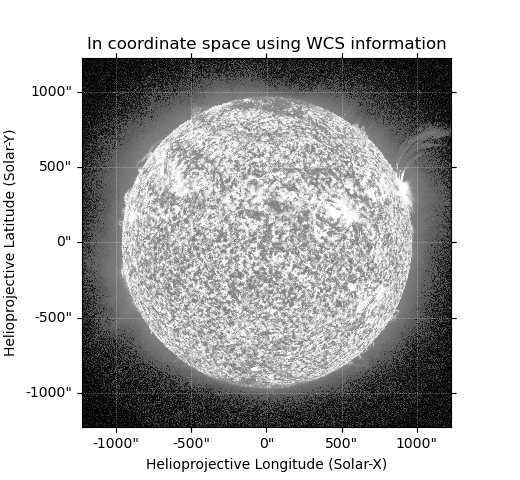
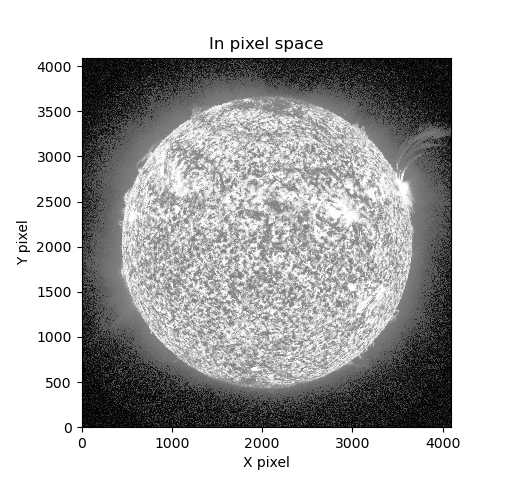
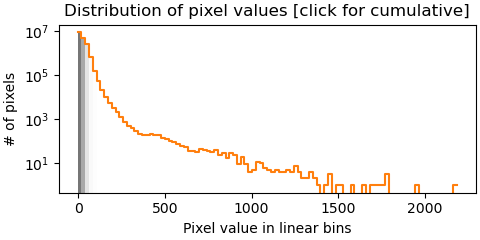
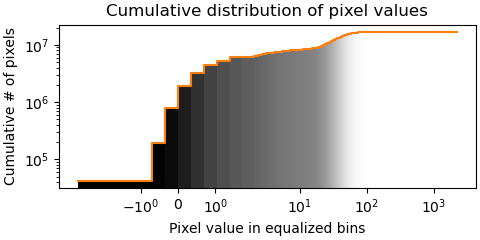

In [9]:
aia_adjusted_map=sunpy.map.Map(aia_adjusted_files[100])
aia_adjusted_map

# Overveiw

## save 4 year solar image

In [3]:
#save four year sun images into pngs
for i in list(range(len(aia_adjusted_files)))[:800]:
    aia_adjusted_map=sunpy.map.Map(aia_adjusted_files[i])
    fig=plt.figure()
    ax = fig.add_subplot(projection=aia_adjusted_map)
    aia_adjusted_map.plot(ax,vmax=1500,vmin=0)
    plt.colorbar()# shrink=0.4)
    title = ax.get_title()
    title='aia_'+title[-19:].replace(':','_').replace('-','_').replace(' ','t')
    plt.tight_layout()
    # plt.subplots_adjust(left=-0.3, bottom=0.1, right=1., top=.9)
#     if(os.path.exists('aia_part//data//AIA_png//'+title+'.png' )):
#         plt.close(fig)
#         continue
    
    plt.savefig('aia_part//data//AIA_png//'+title+'.png',bbox_inches='tight')
    plt.close(fig)

In [4]:
#save four year sun images into pngs
for i in list(range(len(aia_adjusted_files)))[800:]:
    aia_adjusted_map=sunpy.map.Map(aia_adjusted_files[i])
    fig=plt.figure()
    ax = fig.add_subplot(projection=aia_adjusted_map)
    aia_adjusted_map.plot(ax,vmax=1500,vmin=0)
    plt.colorbar()# shrink=0.4)
    title = ax.get_title()
    title='aia_'+title[-19:].replace(':','_').replace('-','_').replace(' ','t')
    plt.tight_layout()
    # plt.subplots_adjust(left=-0.3, bottom=0.1, right=1., top=.9)
#     if(os.path.exists('aia_part//data//AIA_png//'+title+'.png' )):
#         plt.close(fig)
#         continue
    
    plt.savefig('aia_part//data//AIA_png//'+title+'.png',bbox_inches='tight')
    plt.close(fig)

In [5]:
#save four year sun images into a pdf
def convert_images_to_pdf(image_folder, output_path, columns, rows):
    # Get a list of all PNG files in the folder
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

    # Create a new PDF document
    pdf = FPDF()

    # Set the page size to A4 in landscape mode
    pdf.set_auto_page_break(auto=True, margin=0)
    pdf.add_page(orientation='L')
        
    # Calculate the number of grid cells per page
    cells_per_page = columns * rows

    # Define the width and height of each image in the grid
    grid_width = pdf.w / columns
    grid_height = pdf.h / rows

    # Iterate over each image file
    for index, image_file in enumerate(image_files):
        # Open the image using PIL
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)

        # Convert the image to RGB mode if it's not already
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Resize the image to fit within the grid
        image.thumbnail((grid_width, grid_height))

        # Calculate the position of the current grid cell
        x = (index % columns) * grid_width
        y = ((index // columns)%rows)  * grid_height
        
        # Add the image to the current page
        pdf.image(image_path, x=x, y=y, w=image.width, h=image.height)
        
        # If we have added the desired number of images per page, start a new page
        if index != 0 and (index + 1) % cells_per_page == 0:
            pdf.add_page(orientation='L')
            
    # Save the PDF file
    pdf.output(output_path)

In [6]:
# Specify the folder containing the PNG files, the output PDF path, columns, and rows
image_folder = './aia_part/data/AIA_png'
output_pdf = 'aia_part/data/years.pdf'
num_columns = 5
num_rows = 4

# Call the function to convert the images to PDF with the specified grid layout
convert_images_to_pdf(image_folder, output_pdf, num_columns, num_rows)

## calculate DN

In [59]:
aia_adjusted_files=sorted(glob.glob('aia_part/data/AIA_1p5/*adjusted.fits'))
aia_adjusted_map=sunpy.map.Map(aia_adjusted_files[10])

In [35]:
aia_adjusted_map.meta['t_rec']

'2010-06-11T00:00:04Z'

In [163]:
time=datetime.datetime.strptime(aia_adjusted_map.meta['t_rec'],'%Y-%m-%dT%H:%M:%SZ')

In [65]:
def test_kwargs(first, *args, **kwargs):
    print('Required argument: ', first)
    print(type(kwargs))
    for v in args:
        print ('Optional argument (args): ', v)
    for k, v in kwargs.items():
        print ('Optional argument %s (kwargs): %s' % (k, v))

In [73]:
def test_kwargs(first, *args):
    print('Required argument: ', first)
    print(type(args))
    for v in args:
        print ('Optional argument (args): ', v)

In [74]:
a=calculate_DN(aia_adjusted_map,0,10,0)

In [73]:
importlib.reload(aia_part.calculate_DN)
from aia_part.calculate_DN import calculate_DN

In [66]:
a=datetime.datetime(2010,6,11).date()

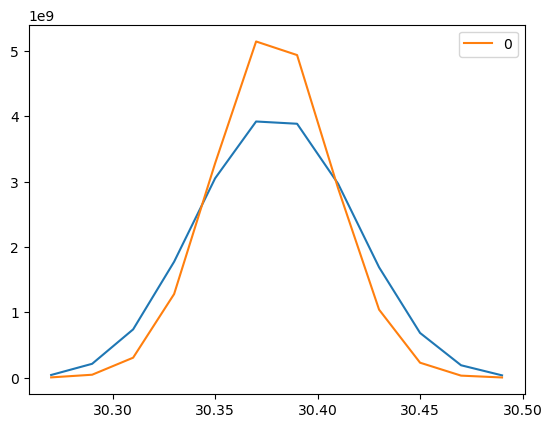

In [75]:
b=calculate_DN(aia_adjusted_map,0,0,0)
fig,ax=plt.subplots()
ax.plot(wavelength_list_aia_absolute,a)
ax.plot(wavelength_list_aia_absolute,b,label='0')
gaussian_fit_aia(wavelength_list_aia_absolute,a)
ax.legend()

### Radial velocity

In [143]:
def calculate_relative_radial_velocity(time):
    # Convert the input time to an Astropy Time object

    t = Time(time)

    # Get the barycentric position and velocity of the Earth
    earth_posvel = get_body_barycentric_posvel('earth', t)
    # Get the barycentric position and velocity of the Sun
    sun_posvel = get_body_barycentric_posvel('sun', t)

    # Calculate the relative position of the Earth with respect to the Sun
    relative_pos = earth_posvel[0] - sun_posvel[0]
    # Calculate the relative velocity of the Earth with respect to the Sun
    relative_vel = earth_posvel[1] - sun_posvel[1]

    # Calculate the radial component of the relative velocity
    radial_velocity = (relative_pos.get_xyz() * relative_vel.get_xyz()).sum() / relative_pos.norm()
    # Convert the velocity to km/s
    radial_velocity = radial_velocity.to(u.km/u.s)

    return radial_velocity

In [122]:
def calculate_relative_radial_velocity(time_list):
    radial_velocity_list=[]
    # Convert the input time to an Astropy Time object
    for time in time_list:
        t = Time(time)

        # Get the barycentric position and velocity of the Earth
        earth_posvel = get_body_barycentric_posvel('earth', t)
        # Get the barycentric position and velocity of the Sun
        sun_posvel = get_body_barycentric_posvel('sun', t)

        # Calculate the relative position of the Earth with respect to the Sun
        relative_pos = earth_posvel[0] - sun_posvel[0]
        # Calculate the relative velocity of the Earth with respect to the Sun
        relative_vel = earth_posvel[1] - sun_posvel[1]

        # Calculate the radial component of the relative velocity
        radial_velocity = (relative_pos.get_xyz() * relative_vel.get_xyz()).sum() / relative_pos.norm()
        # Convert the velocity to km/s
        radial_velocity = radial_velocity.to(u.km/u.s)

        radial_velocity_list.append(radial_velocity.value)
    return radial_velocity_list

In [109]:
start_date = datetime.datetime(2011,1,1,0,0,0)
end_date = datetime.datetime(2012,1,1,0,0,0)
date_list = pd.date_range(start=start_date, end=end_date,freq='D').tolist()

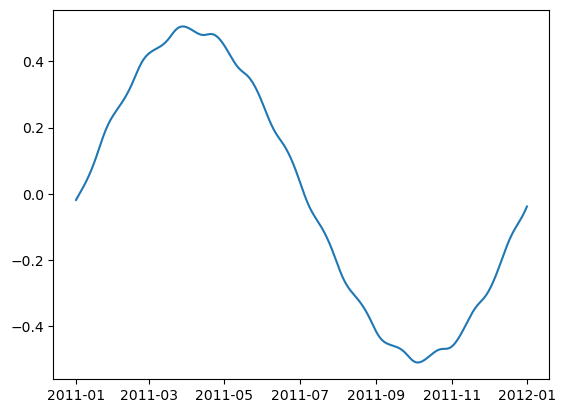

In [123]:
fig,ax=plt.subplots()
ax.plot(date_list,calculate_relative_radial_velocity(date_list))

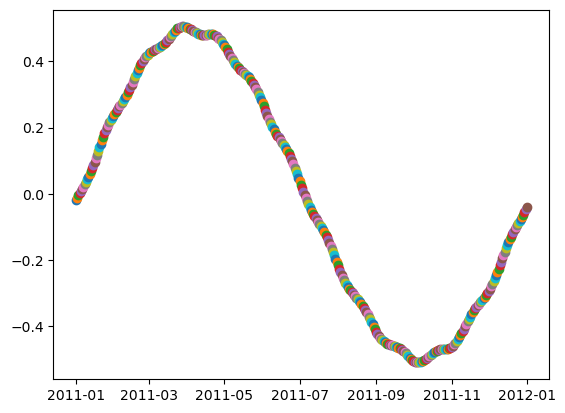

In [126]:
fig,ax=plt.subplots()
for d in date_list:
    ax.scatter(d,calculate_relative_radial_velocity(d))

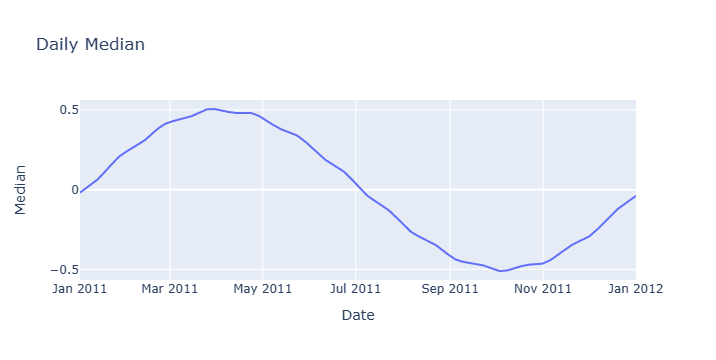

In [124]:
fig = go.Figure(data=go.Scatter(x=date_list, y=calculate_relative_radial_velocity(date_list)))
fig.update_layout(title="Daily Median", xaxis_title="Date", yaxis_title="Median")
fig.show()

In [142]:
calculate_relative_radial_velocity(d)

<Quantity -0.03831708 km / s>

In [144]:
(calculate_relative_radial_velocity(d) ).to(u.nm, equivalencies=u.doppler_optical(30.3783 * u.nm)).value-30.3783

-3.882711947511552e-06

## Parameters

$$
\Delta \lambda=a  T_x^2 + b  T_x+cT_y^2+d T_y+e
$$

In [169]:
angular_radius=sunpy.sun.constants.get('average angular size')
angular_radius=angular_radius.to(u.rad)
#角度遍布整个日面
Tx=np.linspace(-angular_radius,angular_radius,200)
Ty=np.linspace(-angular_radius,angular_radius,200)

def para_visual3(a=8.86e2,d=0.91):
    fig,axs=plt.subplots(nrows=2,ncols=2,figsize=(12,12))
    axs[0,0].plot(Tx.to(u.arcmin),a*Tx**2,label=f'$\Delta \lambda=a  T_x^2$    a={a}',c='b')
    # axs[0,0].plot(Tx.to(u.arcmin),0*Tx,label=r'$\Delta \lambda=b  T_x$',c='b')
    # axs[0,1].plot(Ty.to(u.arcmin),0*Ty**2,label=r'$\Delta \lambda=cT_y^2$',c='g')
    axs[0,1].plot(Ty.to(u.arcmin),d*Ty,label=f'$\Delta \lambda=d T_y$     d={d}',c='g')
    
    # y_min, y_max = axs[0].get_ylim()
    axs[0,0].set_ylim(min(axs[0,0].get_ylim()[0],axs[0,1].get_ylim()[0]), 
                      max(axs[0,0].get_ylim()[1],axs[0,1].get_ylim()[1]))


    axs[0,0].set_ylabel(r'$\Delta \lambda$  (nm)')
    axs[0,0].set_xlabel('Tx (rad)')
    axs[0,1].set_xlabel('Ty (rad)')
    axs[0,1].set_yticklabels([])
    axs[0,1].set_ylabel('')
    axs[0,0].set_title(f'expected optial correction for each pixel: a={a}  d={d}')
    plt.subplots_adjust(wspace=0)
    axs[0,0].legend()
    axs[0,1].legend()


    aia_adjusted_files=sorted(glob.glob('aia_part/data/AIA_1p5/*adjusted.fits'))
    aia_adjusted_map=sunpy.map.Map(aia_adjusted_files[10])


    axs[1,0].plot(wavelength_list_aia_absolute,
            calculate_DN(aia_adjusted_map,a,d,0),
           label=f'a={a}   d={d}')
    axs[1,0].plot(wavelength_list_aia_absolute,
            calculate_DN(aia_adjusted_map,0,0,0),label='ideal condition: optically perfect')
    axs[1,0].legend()
    axs[1,0].set_xlabel('wavelength (nm)')
    axs[1,0].set_title('full image spectrum')

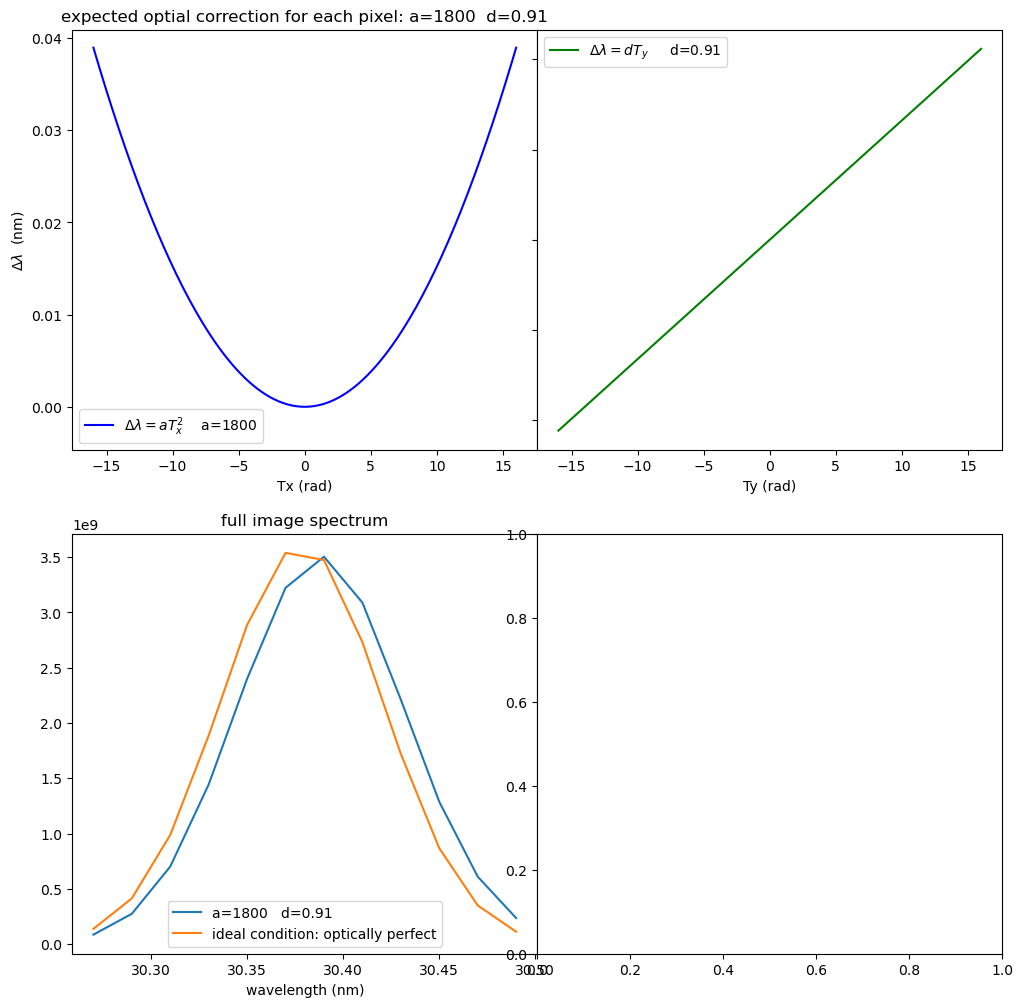

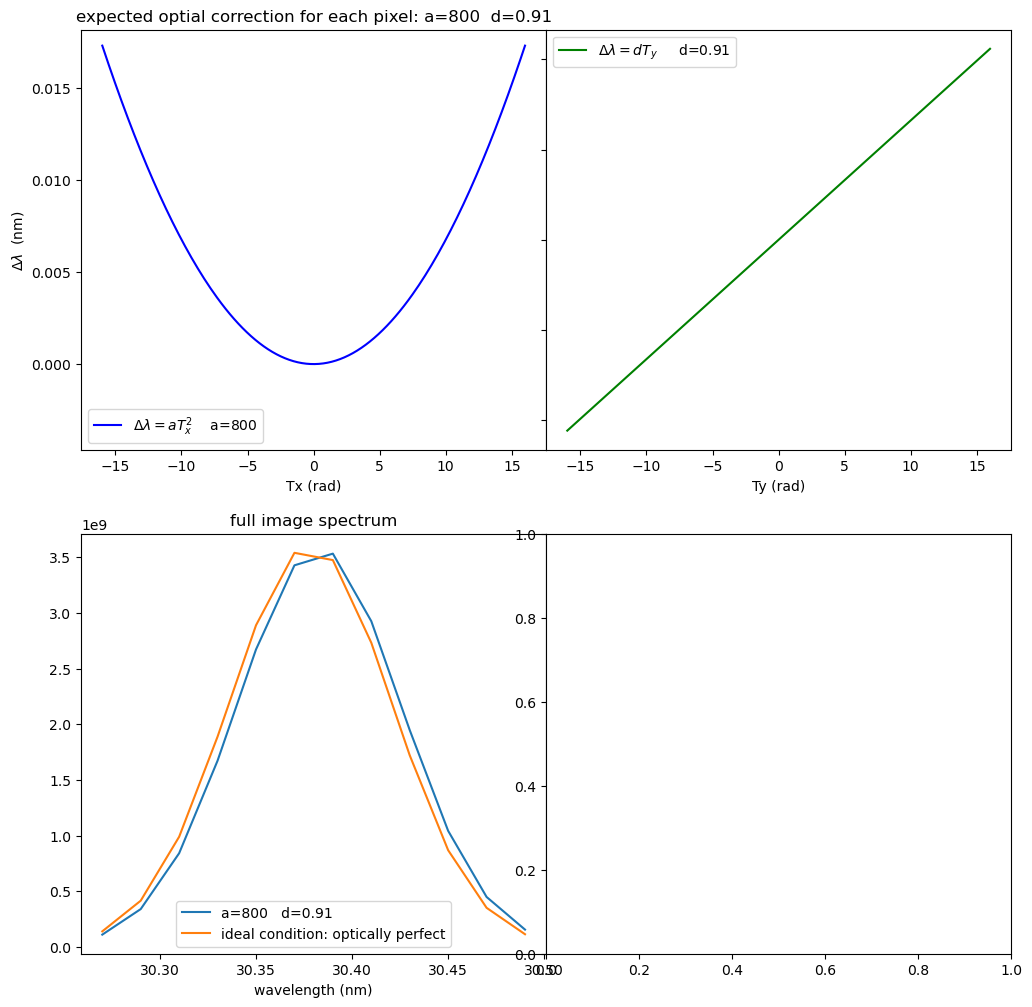

In [170]:
para_visual3(a=1800,d=0.91)
para_visual3(a=800,d=0.91)

### 3d visual

In [4]:
time=datetime.datetime.strptime(aia_adjusted_map.meta['t_rec'],'%Y-%m-%dT%H:%M:%SZ')
date=time.date()
time

NameError: name 'aia_adjusted_map' is not defined

In [5]:
aia_adjusted_maps=[]
for file in aia_adjusted_files[500:510]:
    aia_adjusted_maps.append(sunpy.map.Map(file))

In [8]:
irradiance_list=[]
date_list=[]
for m in aia_adjusted_maps:
    date,irradiance=calculate_DN(m,a=0,d=0,e=0)
    irradiance_list.append(irradiance)
    date_list.append(date)
irradiance_list=np.array(irradiance_list)

In [7]:
irradiance_list

[(datetime.datetime(2011, 10, 15, 0, 0),
  array([3.79583727e+06, 3.36917269e+07, 1.91742855e+08, 6.99673356e+08,
         1.63701144e+09, 2.45577357e+09, 2.36213742e+09, 1.45680770e+09,
         5.76075659e+08, 1.46061937e+08, 2.37451443e+07, 2.47510030e+06])),
 (datetime.datetime(2011, 10, 16, 0, 0),
  array([3.77913880e+06, 3.35437420e+07, 1.90901968e+08, 6.96609721e+08,
         1.62985469e+09, 2.44505410e+09, 2.35184280e+09, 1.45046862e+09,
         5.73572888e+08, 1.45428365e+08, 2.36423074e+07, 2.46439789e+06])),
 (datetime.datetime(2011, 10, 17, 0, 0),
  array([3.81217736e+06, 3.38372171e+07, 1.92573448e+08, 7.02713679e+08,
         1.64414697e+09, 2.46651124e+09, 2.37249764e+09, 1.46321691e+09,
         5.78617896e+08, 1.46708489e+08, 2.38505751e+07, 2.48612349e+06])),
 (datetime.datetime(2011, 10, 18, 0, 0),
  array([3.82800832e+06, 3.39779458e+07, 1.93375566e+08, 7.05645058e+08,
         1.65101585e+09, 2.47683120e+09, 2.38243910e+09, 1.46935737e+09,
         5.81049719e+08,

In [194]:
np.shape(irradiance_list)

(10, 12)

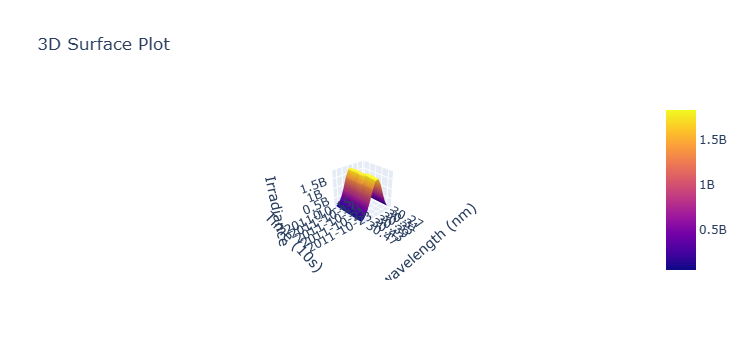

In [196]:
# Generate x and y coordinates for the surface plot
x = np.arange(np.shape(irradiance_list)[1])
y = np.arange(np.shape(irradiance_list)[0])
X, Y = np.meshgrid(x, y)

# Create the surface plot
fig = go.Figure(data=[go.Surface(x=X,y=Y,z=irradiance_list )])

# Customize the layout
fig.update_layout(
    title='3D Surface Plot',
    # width=550, 
    height=700,
    scene=dict(
        xaxis=dict(
            title='wavelength (nm)',
            ticktext=wavelength_list_aia_absolute[::2],  # Set the desired tick labels
            tickvals=x[::2],  # Use the x coordinates as tick values
        ),
        yaxis=dict(title='Time (10s)',
                   ticktext=date_list[::len(date_list)//5],
                  tickvals=y[::len(y)//5]),
        zaxis=dict(title='Irradiance')
    ),
    # margin=dict(l=0,r=20)
)
fig.show()

## file indexed by date

In [247]:
def select_files(start_date,end_date):
    # Directory containing the files
    directory = "aia_part/data/AIA_1p5"

    # List to store the files within the time range
    files_within_range = []

    # Iterate through all the files in the directory
    for filename in os.listdir(directory):
        # Extract the date portion from the file name
        date_str = filename.split("_")[3]+filename.split("_")[4]+filename.split("_")[5].split('t')[0]  # Assuming the date is in the 5th position

        # Convert the date string to a datetime object
        file_date = datetime.datetime.strptime(date_str, "%Y%m%d")

        # Check if the file date is within the specified range
        if start_date <= file_date <= end_date:
            files_within_range.append(
                os.path.join(directory,filename)
                                    )
    return files_within_range

In [261]:
def calculate(selected_files):
    irradiance_list=[]
    date_list=[]
    aia_adjusted_maps=sunpy.map.Map(selected_files)
    for m in aia_adjusted_maps:
        irradiance=calculate_DN(m,a=0,d=0,e=0)
        irradiance_list.append(irradiance)

        time=datetime.datetime.strptime(m.meta['t_rec'],'%Y-%m-%dT%H:%M:%SZ')
        date=time.date()
        date_list.append(date)
    irradiance_list=np.array(irradiance_list)
    return date_list,irradiance_list

In [262]:
def irradiance_plotly_3d(start_date,end_date):
    selected_files=select_files(start_date,end_date)
    date_list,irradiance_list=calculate(selected_files)
    plot_3d(date_list,irradiance_list)
def plot_3d(date_list,irradiance_list):
        # Generate x and y coordinates for the surface plot
    x = np.arange(np.shape(irradiance_list)[1])
    y = np.arange(np.shape(irradiance_list)[0])
    X, Y = np.meshgrid(x, y)

    # Create the surface plot
    fig = go.Figure(data=[go.Surface(x=X,y=Y,z=irradiance_list )])

    # Customize the layout
    fig.update_layout(
        title='3D Surface Plot',
        # width=550, 
        height=700,
        scene=dict(
            xaxis=dict(
                title='wavelength (nm)',
                ticktext=wavelength_list_aia_absolute[::2],  # Set the desired tick labels
                tickvals=x[::2],  # Use the x coordinates as tick values
            ),
            yaxis=dict(title='Time (10s)',
                       ticktext=date_list[::len(date_list)//5],
                      tickvals=y[::len(y)//5]),
            zaxis=dict(title='Irradiance')
        ),
        # margin=dict(l=0,r=20)
    )
    fig.show()

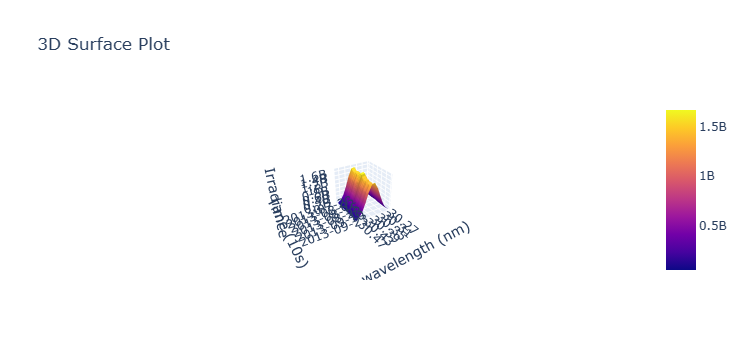

In [264]:
start_date = datetime.datetime(2013, 7, 20)
end_date = datetime.datetime(2013, 9, 23)
irradiance_plotly_3d(start_date,end_date)

## Gaussian fit : time serial

In [30]:
def select_files(start_date,end_date):
    # Directory containing the files
    directory = "aia_part/data/AIA_1p5"

    # List to store the files within the time range
    files_within_range = []

    # Iterate through all the files in the directory
    for filename in os.listdir(directory):
        # Extract the date portion from the file name
        date_str = filename.split("_")[3]+filename.split("_")[4]+filename.split("_")[5].split('t')[0]  # Assuming the date is in the 5th position

        # Convert the date string to a datetime object
        file_date = datetime.datetime.strptime(date_str, "%Y%m%d")

        # Check if the file date is within the specified range
        if start_date <= file_date <= end_date:
            files_within_range.append(
                os.path.join(directory,filename)
                                    )
    return files_within_range

In [51]:
def get_simu(start_date,end_date,a,b,c,d,e):
    selected_files=select_files(start_date,end_date)
    
    date_list = pd.date_range(start=start_date, end=end_date,freq='D').tolist()
    mean_list=[]
    stddev_list=[]
    amplitude_list=[]


    for file in select_files(start_date,end_date):
        aia_adjusted_map=sunpy.map.Map(file)
        irradiance=calculate_DN(aia_adjusted_map,a=900,d=0.9,e=0)

        mean,stddev,amplitude=gaussian_fit_aia(wavelength_list_aia_absolute,irradiance)
        mean_list.append(mean)
        stddev_list.append(stddev)
        amplitude_list.append(amplitude)
        
        
        
    simu_data={
        'date':date_list,
        'mean':mean_list,
        'stddev':stddev_list,
        'amplitude':amplitude_list,
    }
    # print(date_list)
    # print(mean_list)
    # print(stddev_list)
    # print(amplitude_list)
    
    simu_df=pd.DataFrame(simu_data)
    simu_df=simu_df.set_index('date')
    return simu_df

In [54]:
start_date = datetime.datetime(2011, 1, 20)
end_date = datetime.datetime(2011, 3, 1)
simu_df=get_simu(start_date,end_date,a=900,b=0,c=0,d=0.9,e=-0.015)

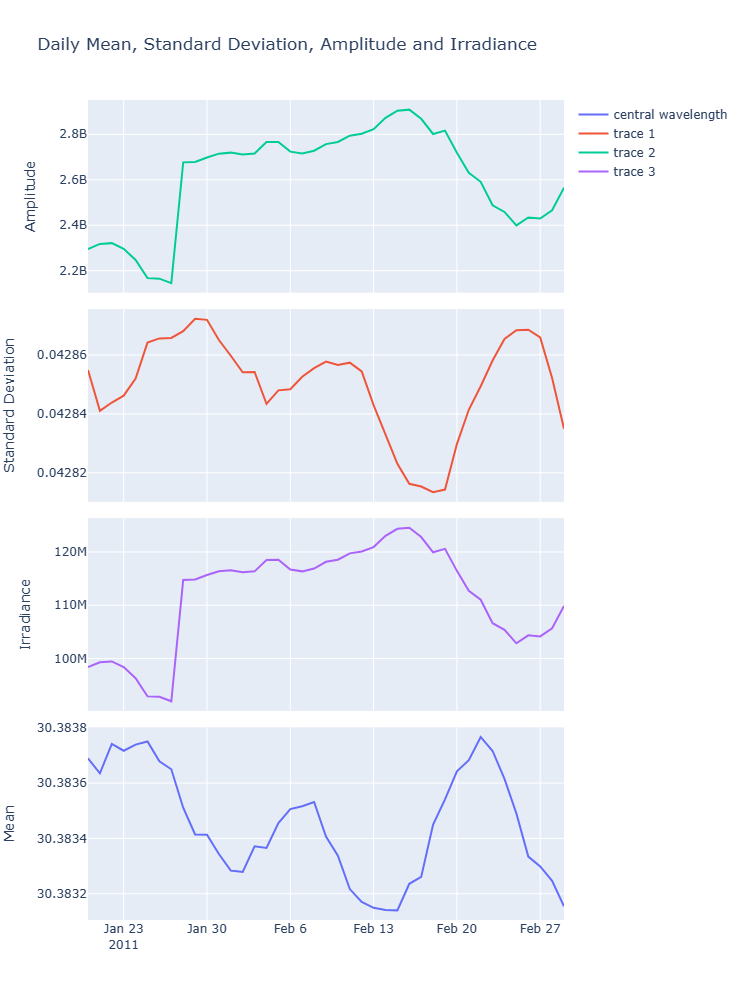

In [55]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.02)

# Add traces for mean
fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['mean'],name='central wavelength'), 
              row=4, col=1,)
fig.update_yaxes(title_text="Mean", row=4, col=1)

# Add traces for stddev
fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['stddev'])
              , row=2, col=1)
fig.update_yaxes(title_text="Standard Deviation", row=2, col=1)

# Add traces for amplitude
fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['amplitude'])
              , row=1, col=1)
fig.update_yaxes(title_text="Amplitude", row=1, col=1)

# Add traces for irradiance
fig.add_trace(go.Scatter(x=simu_df.index, y=simu_df['stddev']*simu_df['amplitude'])
              , row=3, col=1)
fig.update_yaxes(title_text="Irradiance", row=3, col=1)



# Update the figure layout
fig.update_layout(width=600,height=1000,
                  title_text="Daily Mean, Standard Deviation, Amplitude and Irradiance")

# Show the figure
fig.show()

In [24]:
gaussian_fit_aia(wavelength_list_aia_absolute,
                 calculate_DN(aia_adjusted_map,a=900,d=0.9,e=0))

(30.38329487335242, 0.042822733164858, 3196463126.09203)

In [29]:
aia_adjusted_map=sunpy.map.Map(aia_adjusted_files[400])
gaussian_fit_aia(wavelength_list_aia_absolute,
                 calculate_DN(aia_adjusted_map,a=900,d=0.9,e=0))

(30.38308106977512, 0.04280780582407995, 1691712891.8304818)

In [16]:
importlib.reload(aia_part.gaussian_fit_aia )
from aia_part.gaussian_fit_aia import gaussian_fit_aia

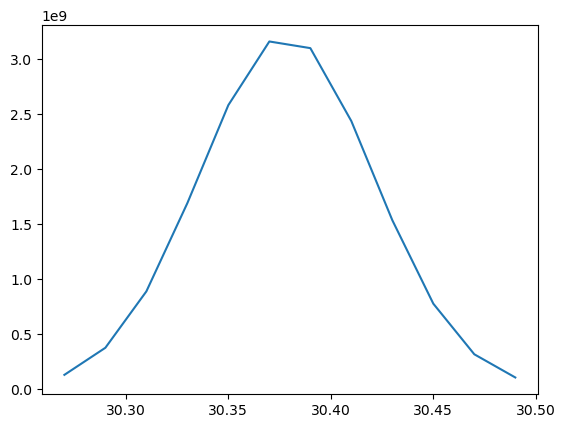

In [18]:
plt.plot(wavelength_list_aia_absolute,calculate_DN(aia_adjusted_map))

In [20]:
gaussian_fwhm_to_sigma

0.42466090014400953

## unit conversion in Ch3

In [76]:
import astropy.units as u
from astropy.constants import au, R_sun
from astropy.stats import gaussian_fwhm_to_sigma
import math


# %%
print(19.8 * (180*3600/(974.634085*math.pi))**2 / 1000)
print(4.3*180*3600/(974.634085*math.pi*1000))

# %%
print(18.66 * (180*3600/(974.634085*math.pi))**2 / 1000)

886.8134384080664
0.9100222129646885
835.7544828633595
